<a href="https://colab.research.google.com/github/josephmarcus9/Liveness-Detection-in-Face-Biometric-Authentication/blob/main/Data_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from torchvision import transforms, utils
import torch
from torch import nn
from torch.nn import functional as F

from PIL import Image
import numpy as np
import os
import itertools

from sklearn.metrics import accuracy_score, confusion_matrix
import sklearn.metrics as metrics
import statistics 
import matplotlib.pyplot as plt
from torchsummary import summary

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
class Data(torch.utils.data.Dataset):
    def __init__(self,db_dir,sub_dir,is_train):
        self.is_train = is_train
        self.file_list,self.label = self.get_file_list(db_dir, sub_dir)
        if self.is_train:
            self.transforms = transforms.Compose([transforms.ToTensor()])
        else:
            self.transforms = transforms.Compose([transforms.ToTensor()])

    def __getitem__(self, index):
        img = self.transforms(Image.open(self.file_list[index]).convert('RGB'))

        label = self.label[index]
        return img,label

    def __len__(self):
        return len(self.file_list)

    def get_file_list(self,db_dir, sub_dir):
        file_list = []
        label_list = []
        # for file in itertools.islice(open(db_dir, "r"),0,len(db_dir)):
        for file in open(db_dir, "r"):
            file = file.replace("\\", "/")
            image_path = db_dir + '/' + file
            path_1 = image_path.strip().split('/')  # strip the '\n'
            retain = path_1[:6]
            retain.append(sub_dir)
            rest = path_1[7:]
            new_file = os.path.join('/', *(retain + rest))
            path_2, file = os.path.split(new_file)
            x = os.path.join(path_2, file)
            file_list.append(x)
            if sub_dir=='ClientRaw':
                label = 0
            else:
                label = 1
            label_list.append(label)
        return file_list,label_list

In [ ]:
#Testing functions works above 
dir = "/content/drive/MyDrive/thesis/NUAA_cropped_2/client_test_raw.txt"
sub = 'ClientRaw'
data = Data(dir,sub, True)
file_list_out=data.get_file_list(dir,sub)[0][:10]
label_list_out=data.get_file_list(dir,sub)[1][:3]
print(file_list_out)

['/content/drive/MyDrive/thesis/NUAA_cropped_2/ClientRaw/0010/0010_01_05_03_115.jpg', '/content/drive/MyDrive/thesis/NUAA_cropped_2/ClientRaw/0010/0010_01_05_03_121.jpg', '/content/drive/MyDrive/thesis/NUAA_cropped_2/ClientRaw/0010/0010_01_05_03_125.jpg', '/content/drive/MyDrive/thesis/NUAA_cropped_2/ClientRaw/0010/0010_01_05_03_129.jpg', '/content/drive/MyDrive/thesis/NUAA_cropped_2/ClientRaw/0010/0010_01_05_03_131.jpg', '/content/drive/MyDrive/thesis/NUAA_cropped_2/ClientRaw/0010/0010_01_05_03_132.jpg', '/content/drive/MyDrive/thesis/NUAA_cropped_2/ClientRaw/0010/0010_01_05_03_133.jpg', '/content/drive/MyDrive/thesis/NUAA_cropped_2/ClientRaw/0010/0010_01_05_03_135.jpg', '/content/drive/MyDrive/thesis/NUAA_cropped_2/ClientRaw/0010/0010_01_05_03_136.jpg', '/content/drive/MyDrive/thesis/NUAA_cropped_2/ClientRaw/0010/0010_01_05_03_140.jpg']


In [ ]:
class Net(nn.Module):
    def __init__(self,num_classes):
        super().__init__()
        self.num_classes = num_classes
        self.relu = nn.ReLU()
        self.lrn = nn.LocalResponseNorm(5, 0.0001, 0.75, 2)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Conv1
        self.conv1 = nn.Conv2d(in_channels=3,out_channels=18,kernel_size=5,stride=1)

        # Conv2
        self.conv2 = nn.Conv2d(18,18,5,stride=1)

        # Conv3
        self.conv3 = nn.Conv2d(18,18,4, stride=1)

        # Conv4
        self.conv4 = nn.Conv2d(18,36, 3, stride=1)

        # fc1
        self.fc1 = nn.Linear(in_features=36 *8*8,out_features=512)

        # fc2
        self.fc2 = nn.Linear(512,120)

        #fc3
        self.fc3 = nn.Linear(120,self.num_classes)


    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.lrn(x)
        x = self.pool(x)

        x = self.conv2(x)
        x = self.relu(x)
        x = self.lrn(x)
        x = self.pool(x)

        x = self.conv3(x)
        x = self.relu(x)

        x = self.conv4(x)
        x = self.relu(x)

        # x = self.conv5(x)
        # x = self.relu(x)
        # x = self.pool(x)

        x = x.view(x.size(0), -1) # Flatten
        

        x = self.fc1(x)
        x = self.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)

        x = self.fc2(x)
        x = self.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)

        x = self.fc3(x)
        return x

In [ ]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")   # use CPU or GPU
learning_rate = 0.01
print(device)

cuda


In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
train_dir_client = "/content/drive/MyDrive/thesis/NUAA_cropped_2/client_test_raw.txt"
sub_dir_client = 'ClientRaw'
train_data_set_client = Data(train_dir_client, sub_dir_client, True)

# Train Imposter
train_dir_imposter = "/content/drive/MyDrive/thesis/NUAA_cropped_2/imposter_test_raw.txt"
sub_dir_imposter = 'ImposterRaw'
train_data_set_imposter = Data(train_dir_imposter, sub_dir_imposter, True)

# Train combined
train_data_set = train_data_set_client + train_data_set_imposter

# Test client
test_dir_client = "/content/drive/MyDrive/thesis/NUAA_cropped_2/client_train_raw.txt"
test_data_set_client = Data(test_dir_client, sub_dir_client, False)

# Test Imposter
test_dir_imposter = "/content/drive/MyDrive/thesis/NUAA_cropped_2/imposter_train_raw.txt"
test_data_set_imposter = Data(test_dir_imposter, sub_dir_imposter, False)

# Test combined
test_data_set = test_data_set_client + test_data_set_imposter

In [ ]:
batch_size_value=5
train_data_loader = torch.utils.data.DataLoader(train_data_set, shuffle=True,batch_size=batch_size_value, num_workers=2)
test_data_loader =torch.utils.data.DataLoader(test_data_set,shuffle=True, batch_size=batch_size_value, num_workers=2)

In [ ]:
def train(net,dataloader,optimizer,epoch):
  net.train()
  train_losses=[]
  for e in range(epoch):
      running_loss=0
      for batch_idx, (X, y) in enumerate(dataloader):
          X, y = X.to(device), y.to(device)
          optimizer.zero_grad()
          output = net(X)
          loss = F.cross_entropy(output, y)
          loss.backward()
          optimizer.step()
          running_loss += loss.item()
          batch_nos=200
          if batch_idx%batch_nos==199:
            print('epoch: ',e+1,'batch: ',batch_idx+1,"running_loss: ",running_loss/batch_nos ) # print every 100 mini-batches
            train_losses.append(running_loss/batch_nos)
            running_loss=0
      # train_loss=running_loss/len(dataloader)
      # print('epoch: ',e,'train_loss',train_loss)
  return train_losses

In [ ]:
epoch_no=2
net = Net(2).to(device)
optimizer = torch.optim.SGD(list(net.parameters()), lr=0.01) #could increase
x=train(net,train_data_loader,optimizer,epoch_no)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


epoch:  1 batch:  200 running_loss:  0.6736149424314499
epoch:  1 batch:  400 running_loss:  0.6474957099556923
epoch:  1 batch:  600 running_loss:  0.651401419788599
epoch:  1 batch:  800 running_loss:  0.6521847571432591
epoch:  1 batch:  1000 running_loss:  0.6654390993714333
epoch:  1 batch:  1200 running_loss:  0.6669027541577816
epoch:  1 batch:  1400 running_loss:  0.6579850347340107
epoch:  1 batch:  1600 running_loss:  0.6522603678703308
epoch:  1 batch:  1800 running_loss:  0.6583060854673386
epoch:  2 batch:  200 running_loss:  0.6490180543065072
epoch:  2 batch:  400 running_loss:  0.6017071764171124
epoch:  2 batch:  600 running_loss:  0.4871781184896827
epoch:  2 batch:  800 running_loss:  0.30993524548597634
epoch:  2 batch:  1000 running_loss:  0.2101951492181979
epoch:  2 batch:  1200 running_loss:  0.3642804957332555
epoch:  2 batch:  1400 running_loss:  0.2043309348647017
epoch:  2 batch:  1600 running_loss:  0.12664775595403627
epoch:  2 batch:  1800 running_loss:  

In [ ]:
len_train_set=len(train_data_loader)*batch_size_value;int(len(train_data_loader)/200)

9

In [ ]:
epoch_losses=x[int(len(train_data_loader)/200)-1:len(x):int(len(train_data_loader)/200)]
epoch_losses.insert(0,x[0])
epoch_losses

[0.6736149424314499, 0.6583060854673386, 0.13020919599330227]

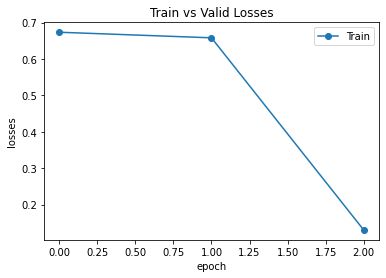

In [ ]:
plt.plot(epoch_losses,'-o')
plt.xlabel('epoch')
plt.ylabel('losses')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid Losses')
plt.savefig("/content/drive/My Drive/thesis/Train vs Valid Losses.png")
#plt.show()



In [ ]:
PATH = '/content/drive/MyDrive/thesis/cifar_net.pth' #Save 
torch.save(net.state_dict(), PATH)

In [ ]:
def metric(predict_proba, labels2):
    predict = np.argmax(predict_proba, axis=1)
    labels2 = np.asarray(labels2)
    con_matrix = confusion_matrix(labels2, predict)
    TP = con_matrix[0][0]
    FN = con_matrix[0][1]
    FP = con_matrix[1][0]
    TN = con_matrix[1][1]

    print("True Positive-->The classifier model predicted " + str(
        TP) + " real(positive) samples as real(Positive)")  # reals correctly predicted
    print("False Negative-->The classifier model predicted " + str(
        FN) + " real(Positive) samples as spoof(Negative)")  # real predicted as spoof
    print("False Positive-->The classifier model predicted " + str(
        FP) + " spoof(Negative) samples as real(Positive)")  # Spoof predicted as real
    print("True Negative-->The classifier model predicted " + str(
        TN) + " spoof(Negative) samples as spoof(Negative)")  # Spoofs correctly predicted

    print("Precision of the Linear SVM:"
          , (TP / (TP + FP)))
    print("Recall of the Linear SVM:", (TP / (TP + FN)))
    print("Accuracy of the Linear SVM:", ((TP + TN) / (TP + TN + FP + FN)))

    far = FP / (FP + TN)  # apcer
    frr = FN / (TP + FN)  # bpcer
    hter = (far + frr) / 2  # hter


    # print(predict_proba[:5])
    # print([i[1] for i in predict_proba[:5]])

    new_predict_proba = [i[1] for i in predict_proba]
    fpr, tpr, threshold = metrics.roc_curve(labels2, new_predict_proba, pos_label=1)
    roc_auc = metrics.auc(fpr, tpr)
    dist = abs((1 - fpr) - tpr)
    eer = fpr[np.argmin(dist)]
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label='AUC = %0.2f' % roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.savefig("/content/drive/My Drive/thesis/roc.png")
    # plt.show()
    return far, frr, hter, eer

In [ ]:
def test(data_loader,net):
  net.eval()
  correct = 0
  total = 0
  running_loss=0
  scores = []
  all_y = []
  # since we're not training, we don't need to calculate the gradients for our outputs

  with torch.no_grad(): #Wont be calculating the gradients 
    for batch_idx, (X, y) in enumerate(data_loader):
      X, y = X.to(device), y.to(device)
      outputs = net(X)
      scores.extend(F.softmax(outputs).detach().cpu().numpy())
      all_y.extend(y.cpu().numpy())
      # the class with the highest energy is what we choose as prediction
      _, predicted = torch.max(F.softmax(outputs).data, 1)

      total += y.size(0)
      correct += (predicted == y).sum().item()
  return scores, all_y, total, correct


In [ ]:
net = Net(2).to(device)
net.load_state_dict(torch.load(PATH))
testing=test(test_data_loader,net)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


True Positive-->The classifier model predicted 746 real(positive) samples as real(Positive)
False Negative-->The classifier model predicted 997 real(Positive) samples as spoof(Negative)
False Positive-->The classifier model predicted 13 spoof(Negative) samples as real(Positive)
True Negative-->The classifier model predicted 1735 spoof(Negative) samples as spoof(Negative)
Precision of the Linear SVM: 0.9828722002635046
Recall of the Linear SVM: 0.4279977051061388
Accuracy of the Linear SVM: 0.7106846175880837
APCER: 0.007437070938215103
BPCER: 0.5720022948938611
HTER: 0.2897196829160381
EER 0.14457831325301204
Total: 3491 Correct:  2481


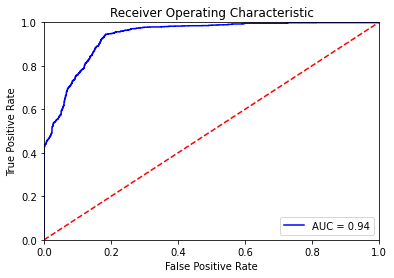

In [ ]:
apcer, bpcer, hter, eer = metric(testing[0], testing[1])

print('APCER:', apcer)
print('BPCER:', bpcer)
print('HTER:', hter)
print('EER', eer)
print('Total:', testing[2], 'Correct: ', testing[3])

In [ ]:
#Their metric functions 
# EER(testing[1], testing[0])
# HTER(testing[1], testing[0], 0.5)

In [ ]:
def imshow(img):
    #img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

classes=('real','spoof')

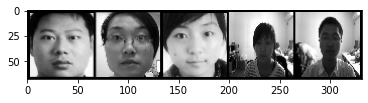

GroundTruth:  spoof  real spoof  real  real


In [ ]:
dataiter = iter(test_data_loader)
images, labels = dataiter.next()

# print images
imshow(utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(5)))

In [ ]:
# outputs = net(images);outputs
# _, predicted = torch.max(outputs.data, 1)



net = Net(2).to(device)
net.load_state_dict(torch.load(PATH))
images=images.to(device)
outputs = net(images)


# scores.extend(F.softmax(outputs).detach().cpu().numpy())
# all_y.extend(labels.cpu().numpy())
# the class with the highest energy is what we choose as prediction
_, predicted = torch.max(outputs.data, 1)

In [ ]:


print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(5)))

Predicted:  spoof spoof spoof  real  real


In [ ]:

summary(net, input_size=(3,64,64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 18, 60, 60]           1,368
              ReLU-2           [-1, 18, 60, 60]               0
 LocalResponseNorm-3           [-1, 18, 60, 60]               0
         MaxPool2d-4           [-1, 18, 30, 30]               0
            Conv2d-5           [-1, 18, 26, 26]           8,118
              ReLU-6           [-1, 18, 26, 26]               0
 LocalResponseNorm-7           [-1, 18, 26, 26]               0
         MaxPool2d-8           [-1, 18, 13, 13]               0
            Conv2d-9           [-1, 18, 10, 10]           5,202
             ReLU-10           [-1, 18, 10, 10]               0
           Conv2d-11             [-1, 36, 8, 8]           5,868
             ReLU-12             [-1, 36, 8, 8]               0
           Linear-13                  [-1, 512]       1,180,160
             ReLU-14                  [

In [ ]:
images[0].shape

torch.Size([3, 64, 64])